In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm.notebook import trange
from loguru import logger

# sys.path.append('..')
# from training.src.data_processing import tfrecords as tfr
import training.src.data_processing.tfrecords as tfr

2023-12-06 12:07:39.292727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 12:07:39.295389: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 12:07:39.334788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 12:07:39.334813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 12:07:39.335700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
root = Path.cwd().parent
data = root / 'training' / 'data'
tfrec = data / 'tfrec'

In [3]:
df = pd.read_csv(data / 'train.csv')

In [22]:
df['longitude'] = df.groupby('class_id')['longitude'].transform(lambda x: x.fillna(x.median()))
df['latitude'] = df.groupby('class_id')['latitude'].transform(lambda x: x.fillna(x.median()))

In [23]:
df['family'] = df['family'].fillna(r'NA')
df['order'] = df['order'].fillna(r'NA')

In [24]:
df['date'] = pd.to_datetime(df['date'])

In [25]:
df['day'] = df['date'].dt.day_of_year
df['month'] = df['date'].dt.month

In [26]:
df['image_dir'] = df.apply(lambda x: f"{x['kingdom']}_{x['phylum']}_{x['class']}_{x['order']}_{x['family']}_{x['genus']}_{x['specific_epithet']}", axis=1)
df['file_path'] = df.apply(lambda x: f"{data}/train/{x['image_dir']}/{x['file_name']}", axis=1)

In [10]:
df.to_csv(data / 'train.csv', index=False)

In [16]:
df.value_counts(['height', 'width']).head(10)

height  width
500     375      33150
375     500      25808
333     500       6194
500     281       4036
281     500       3142
500     500       2595
600     800       2433
800     600       1744
500     333       1004
334     500        927
Name: count, dtype: int64

In [33]:
df.isna().sum()

kingdom                 0
name                    0
family                  0
supercategory           0
phylum                  0
order                   0
genus                   0
class                   0
license                 0
file_name               0
rights_holder           0
height                  0
width                   0
location_uncertainty    0
date                    0
valid                   0
user_id                 0
latitude                0
longitude               0
dset                    0
dataset                 0
file_path               0
specific_epithet        0
image_dir_name          0
image_id                0
class_id                0
gcs_path                0
class_priors            0
image_dir               0
dtype: int64

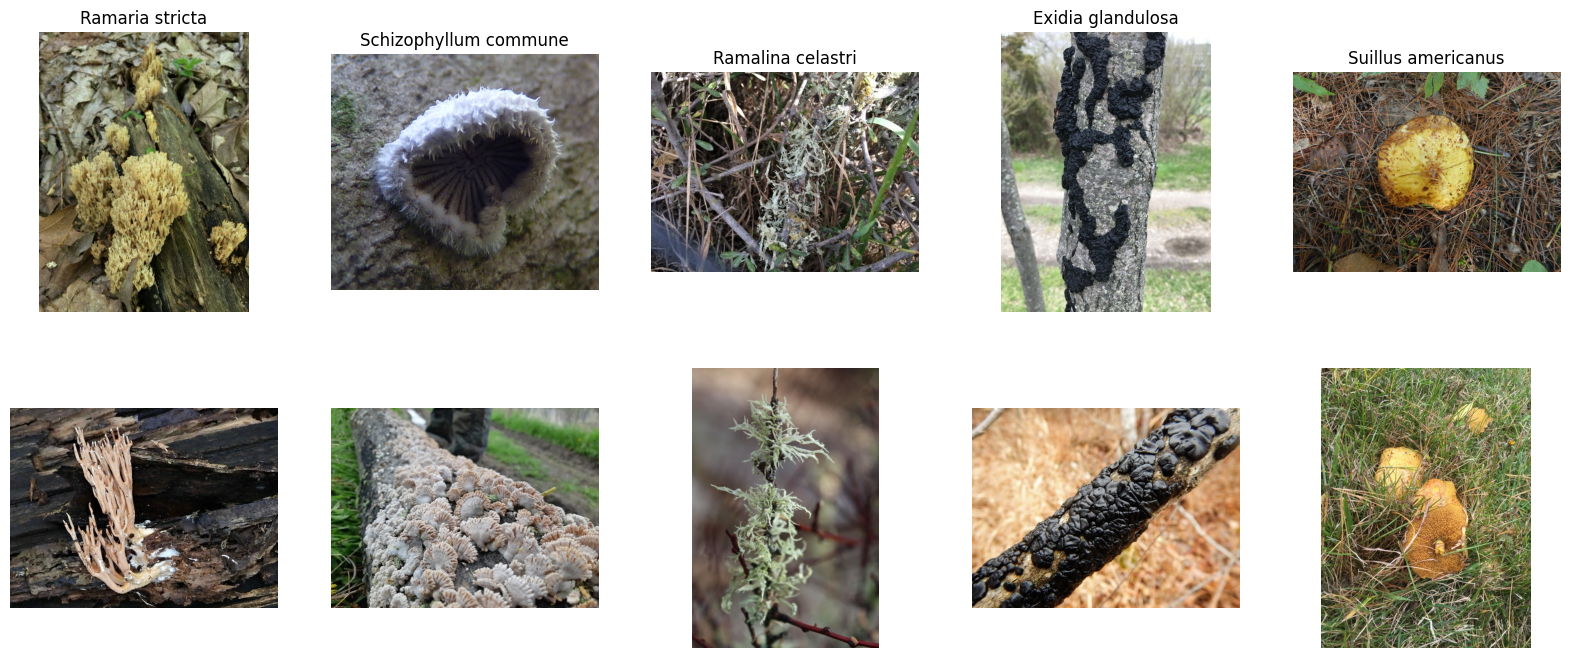

In [22]:
plt.figure(figsize=(20, 8))
classes = df['name'].sort_values().sample(5)
for i, cls in enumerate(classes, start=1):
    imgs = df[df['name'] == cls].sample(2)['file_path']
    for j, img in enumerate(imgs):
        im = cv2.imread(str(img))
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.subplot(2, 5, i + (j * 5))
        if j == 0:
            plt.gca().set_title(cls)
        plt.axis('off')
        plt.imshow(im)

In [4]:
df = df.sample(frac=1).sample(frac=1).reset_index(drop=True)

In [5]:
num_train_records = 199
IMGS = df['file_path'].to_list()
SIZE = len(IMGS) // num_train_records
CT = len(IMGS) // SIZE + int(len(IMGS) % SIZE != 0)

In [6]:
# iterate over the number of tfrecords
for j in trange(CT):
    logger.info(f"Writing {j:02d} of {CT} tfrecords")
    CT2 = min(
        SIZE, len(IMGS) - j * SIZE
    )  # get the number of images in a tfrecord

    # create the path to write the tfrecord to
    path = tfrec / "tfrecords-jpeg-raw"
    path.mkdir(parents=True, exist_ok=True)

    with tf.io.TFRecordWriter(
        str(path / f"train{j:02d}-{CT2}.tfrec")
    ) as writer:

        # Iterate through the rows of the dataframe
        for k in trange(CT2, leave=False):
            # if k % 100 == 0:
                # logger.info(f"Writing {k:02d} of {CT2} train tfrecord images")
            row = df.iloc[SIZE * j + k]
            # load image from disk, change RGB to cv2 default BGR format, resize to reshape_sizes and encode as jpeg
            img = cv2.imread(row.file_path)
            img = cv2.imencode(".jpg", img)[1].tobytes()

            # Serialize data
            example = tfr.serialize_example(
                img,
                row.file_name.split(".")[0].encode('utf8'),
                row.width,
                row.height,
                row.class_id,
            )
            writer.write(example)

  0%|          | 0/200 [00:00<?, ?it/s]

2023-12-06 12:08:26.930 | INFO     | __main__:<module>:3 - Writing 00 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:32.071 | INFO     | __main__:<module>:3 - Writing 01 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:36.858 | INFO     | __main__:<module>:3 - Writing 02 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:41.786 | INFO     | __main__:<module>:3 - Writing 03 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:46.819 | INFO     | __main__:<module>:3 - Writing 04 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:51.836 | INFO     | __main__:<module>:3 - Writing 05 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:08:56.785 | INFO     | __main__:<module>:3 - Writing 06 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:01.525 | INFO     | __main__:<module>:3 - Writing 07 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:06.526 | INFO     | __main__:<module>:3 - Writing 08 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:11.633 | INFO     | __main__:<module>:3 - Writing 09 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:16.553 | INFO     | __main__:<module>:3 - Writing 10 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:21.460 | INFO     | __main__:<module>:3 - Writing 11 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:26.459 | INFO     | __main__:<module>:3 - Writing 12 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:31.419 | INFO     | __main__:<module>:3 - Writing 13 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:36.429 | INFO     | __main__:<module>:3 - Writing 14 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:41.289 | INFO     | __main__:<module>:3 - Writing 15 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:46.091 | INFO     | __main__:<module>:3 - Writing 16 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:50.875 | INFO     | __main__:<module>:3 - Writing 17 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:09:55.920 | INFO     | __main__:<module>:3 - Writing 18 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:01.004 | INFO     | __main__:<module>:3 - Writing 19 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:05.942 | INFO     | __main__:<module>:3 - Writing 20 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:10.821 | INFO     | __main__:<module>:3 - Writing 21 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:15.759 | INFO     | __main__:<module>:3 - Writing 22 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:20.449 | INFO     | __main__:<module>:3 - Writing 23 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:25.140 | INFO     | __main__:<module>:3 - Writing 24 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:29.838 | INFO     | __main__:<module>:3 - Writing 25 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:34.503 | INFO     | __main__:<module>:3 - Writing 26 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:39.382 | INFO     | __main__:<module>:3 - Writing 27 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:44.441 | INFO     | __main__:<module>:3 - Writing 28 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:49.589 | INFO     | __main__:<module>:3 - Writing 29 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:54.417 | INFO     | __main__:<module>:3 - Writing 30 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:10:59.276 | INFO     | __main__:<module>:3 - Writing 31 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:03.930 | INFO     | __main__:<module>:3 - Writing 32 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:08.739 | INFO     | __main__:<module>:3 - Writing 33 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:13.440 | INFO     | __main__:<module>:3 - Writing 34 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:18.274 | INFO     | __main__:<module>:3 - Writing 35 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:23.180 | INFO     | __main__:<module>:3 - Writing 36 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:27.965 | INFO     | __main__:<module>:3 - Writing 37 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:32.631 | INFO     | __main__:<module>:3 - Writing 38 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:37.348 | INFO     | __main__:<module>:3 - Writing 39 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:42.152 | INFO     | __main__:<module>:3 - Writing 40 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:47.314 | INFO     | __main__:<module>:3 - Writing 41 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:52.569 | INFO     | __main__:<module>:3 - Writing 42 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:11:57.620 | INFO     | __main__:<module>:3 - Writing 43 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:02.362 | INFO     | __main__:<module>:3 - Writing 44 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:07.068 | INFO     | __main__:<module>:3 - Writing 45 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:11.655 | INFO     | __main__:<module>:3 - Writing 46 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:16.274 | INFO     | __main__:<module>:3 - Writing 47 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:20.921 | INFO     | __main__:<module>:3 - Writing 48 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:25.710 | INFO     | __main__:<module>:3 - Writing 49 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:30.212 | INFO     | __main__:<module>:3 - Writing 50 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:34.746 | INFO     | __main__:<module>:3 - Writing 51 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:39.583 | INFO     | __main__:<module>:3 - Writing 52 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:44.089 | INFO     | __main__:<module>:3 - Writing 53 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:48.824 | INFO     | __main__:<module>:3 - Writing 54 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:53.455 | INFO     | __main__:<module>:3 - Writing 55 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:12:58.055 | INFO     | __main__:<module>:3 - Writing 56 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:13:02.570 | INFO     | __main__:<module>:3 - Writing 57 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:13:17.701 | INFO     | __main__:<module>:3 - Writing 58 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:13:33.576 | INFO     | __main__:<module>:3 - Writing 59 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:13:48.630 | INFO     | __main__:<module>:3 - Writing 60 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:02.406 | INFO     | __main__:<module>:3 - Writing 61 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:21.433 | INFO     | __main__:<module>:3 - Writing 62 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:28.026 | INFO     | __main__:<module>:3 - Writing 63 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:33.132 | INFO     | __main__:<module>:3 - Writing 64 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:38.304 | INFO     | __main__:<module>:3 - Writing 65 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:44.113 | INFO     | __main__:<module>:3 - Writing 66 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:49.769 | INFO     | __main__:<module>:3 - Writing 67 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:54.878 | INFO     | __main__:<module>:3 - Writing 68 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:14:59.943 | INFO     | __main__:<module>:3 - Writing 69 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:05.193 | INFO     | __main__:<module>:3 - Writing 70 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:10.438 | INFO     | __main__:<module>:3 - Writing 71 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:15.182 | INFO     | __main__:<module>:3 - Writing 72 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:20.016 | INFO     | __main__:<module>:3 - Writing 73 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:24.631 | INFO     | __main__:<module>:3 - Writing 74 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:29.355 | INFO     | __main__:<module>:3 - Writing 75 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:33.994 | INFO     | __main__:<module>:3 - Writing 76 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:38.549 | INFO     | __main__:<module>:3 - Writing 77 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:43.150 | INFO     | __main__:<module>:3 - Writing 78 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:47.888 | INFO     | __main__:<module>:3 - Writing 79 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:52.723 | INFO     | __main__:<module>:3 - Writing 80 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:15:57.491 | INFO     | __main__:<module>:3 - Writing 81 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:02.090 | INFO     | __main__:<module>:3 - Writing 82 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:06.597 | INFO     | __main__:<module>:3 - Writing 83 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:11.170 | INFO     | __main__:<module>:3 - Writing 84 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:15.918 | INFO     | __main__:<module>:3 - Writing 85 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:20.526 | INFO     | __main__:<module>:3 - Writing 86 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:25.157 | INFO     | __main__:<module>:3 - Writing 87 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:29.754 | INFO     | __main__:<module>:3 - Writing 88 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:34.372 | INFO     | __main__:<module>:3 - Writing 89 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:39.139 | INFO     | __main__:<module>:3 - Writing 90 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:43.877 | INFO     | __main__:<module>:3 - Writing 91 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:48.568 | INFO     | __main__:<module>:3 - Writing 92 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:53.847 | INFO     | __main__:<module>:3 - Writing 93 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:16:58.510 | INFO     | __main__:<module>:3 - Writing 94 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:03.398 | INFO     | __main__:<module>:3 - Writing 95 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:07.895 | INFO     | __main__:<module>:3 - Writing 96 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:12.538 | INFO     | __main__:<module>:3 - Writing 97 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:17.097 | INFO     | __main__:<module>:3 - Writing 98 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:21.723 | INFO     | __main__:<module>:3 - Writing 99 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:26.233 | INFO     | __main__:<module>:3 - Writing 100 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:30.788 | INFO     | __main__:<module>:3 - Writing 101 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:35.458 | INFO     | __main__:<module>:3 - Writing 102 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:40.094 | INFO     | __main__:<module>:3 - Writing 103 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:44.699 | INFO     | __main__:<module>:3 - Writing 104 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:49.153 | INFO     | __main__:<module>:3 - Writing 105 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:53.837 | INFO     | __main__:<module>:3 - Writing 106 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:17:58.424 | INFO     | __main__:<module>:3 - Writing 107 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:02.952 | INFO     | __main__:<module>:3 - Writing 108 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:07.451 | INFO     | __main__:<module>:3 - Writing 109 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:11.994 | INFO     | __main__:<module>:3 - Writing 110 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:16.566 | INFO     | __main__:<module>:3 - Writing 111 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:21.025 | INFO     | __main__:<module>:3 - Writing 112 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:25.451 | INFO     | __main__:<module>:3 - Writing 113 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:29.907 | INFO     | __main__:<module>:3 - Writing 114 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:34.488 | INFO     | __main__:<module>:3 - Writing 115 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:38.889 | INFO     | __main__:<module>:3 - Writing 116 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:43.512 | INFO     | __main__:<module>:3 - Writing 117 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:48.088 | INFO     | __main__:<module>:3 - Writing 118 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:52.811 | INFO     | __main__:<module>:3 - Writing 119 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:18:57.376 | INFO     | __main__:<module>:3 - Writing 120 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:01.960 | INFO     | __main__:<module>:3 - Writing 121 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:06.388 | INFO     | __main__:<module>:3 - Writing 122 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:11.092 | INFO     | __main__:<module>:3 - Writing 123 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:15.551 | INFO     | __main__:<module>:3 - Writing 124 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:19.943 | INFO     | __main__:<module>:3 - Writing 125 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:24.398 | INFO     | __main__:<module>:3 - Writing 126 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:29.057 | INFO     | __main__:<module>:3 - Writing 127 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:33.590 | INFO     | __main__:<module>:3 - Writing 128 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:38.149 | INFO     | __main__:<module>:3 - Writing 129 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:42.712 | INFO     | __main__:<module>:3 - Writing 130 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:47.111 | INFO     | __main__:<module>:3 - Writing 131 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:51.663 | INFO     | __main__:<module>:3 - Writing 132 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:19:56.178 | INFO     | __main__:<module>:3 - Writing 133 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:00.588 | INFO     | __main__:<module>:3 - Writing 134 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:05.014 | INFO     | __main__:<module>:3 - Writing 135 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:09.465 | INFO     | __main__:<module>:3 - Writing 136 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:14.145 | INFO     | __main__:<module>:3 - Writing 137 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:18.546 | INFO     | __main__:<module>:3 - Writing 138 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:23.092 | INFO     | __main__:<module>:3 - Writing 139 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:27.519 | INFO     | __main__:<module>:3 - Writing 140 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:32.031 | INFO     | __main__:<module>:3 - Writing 141 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:36.531 | INFO     | __main__:<module>:3 - Writing 142 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:41.006 | INFO     | __main__:<module>:3 - Writing 143 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:45.616 | INFO     | __main__:<module>:3 - Writing 144 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:50.188 | INFO     | __main__:<module>:3 - Writing 145 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:54.774 | INFO     | __main__:<module>:3 - Writing 146 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:20:59.343 | INFO     | __main__:<module>:3 - Writing 147 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:04.211 | INFO     | __main__:<module>:3 - Writing 148 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:08.778 | INFO     | __main__:<module>:3 - Writing 149 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:13.291 | INFO     | __main__:<module>:3 - Writing 150 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:17.666 | INFO     | __main__:<module>:3 - Writing 151 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:22.351 | INFO     | __main__:<module>:3 - Writing 152 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:26.843 | INFO     | __main__:<module>:3 - Writing 153 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:31.387 | INFO     | __main__:<module>:3 - Writing 154 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:35.753 | INFO     | __main__:<module>:3 - Writing 155 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:40.401 | INFO     | __main__:<module>:3 - Writing 156 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:45.848 | INFO     | __main__:<module>:3 - Writing 157 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:50.846 | INFO     | __main__:<module>:3 - Writing 158 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:21:55.775 | INFO     | __main__:<module>:3 - Writing 159 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:00.732 | INFO     | __main__:<module>:3 - Writing 160 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:05.641 | INFO     | __main__:<module>:3 - Writing 161 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:10.588 | INFO     | __main__:<module>:3 - Writing 162 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:15.678 | INFO     | __main__:<module>:3 - Writing 163 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:20.500 | INFO     | __main__:<module>:3 - Writing 164 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:25.332 | INFO     | __main__:<module>:3 - Writing 165 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:30.123 | INFO     | __main__:<module>:3 - Writing 166 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:34.754 | INFO     | __main__:<module>:3 - Writing 167 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:39.359 | INFO     | __main__:<module>:3 - Writing 168 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:44.080 | INFO     | __main__:<module>:3 - Writing 169 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:48.725 | INFO     | __main__:<module>:3 - Writing 170 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:53.307 | INFO     | __main__:<module>:3 - Writing 171 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:22:58.010 | INFO     | __main__:<module>:3 - Writing 172 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:02.732 | INFO     | __main__:<module>:3 - Writing 173 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:07.304 | INFO     | __main__:<module>:3 - Writing 174 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:11.785 | INFO     | __main__:<module>:3 - Writing 175 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:16.368 | INFO     | __main__:<module>:3 - Writing 176 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:21.468 | INFO     | __main__:<module>:3 - Writing 177 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:26.536 | INFO     | __main__:<module>:3 - Writing 178 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:31.775 | INFO     | __main__:<module>:3 - Writing 179 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:37.108 | INFO     | __main__:<module>:3 - Writing 180 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:42.181 | INFO     | __main__:<module>:3 - Writing 181 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:47.111 | INFO     | __main__:<module>:3 - Writing 182 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:51.877 | INFO     | __main__:<module>:3 - Writing 183 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:23:56.385 | INFO     | __main__:<module>:3 - Writing 184 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:00.982 | INFO     | __main__:<module>:3 - Writing 185 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:05.500 | INFO     | __main__:<module>:3 - Writing 186 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:10.131 | INFO     | __main__:<module>:3 - Writing 187 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:14.751 | INFO     | __main__:<module>:3 - Writing 188 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:19.371 | INFO     | __main__:<module>:3 - Writing 189 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:23.963 | INFO     | __main__:<module>:3 - Writing 190 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:28.572 | INFO     | __main__:<module>:3 - Writing 191 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:33.014 | INFO     | __main__:<module>:3 - Writing 192 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:37.647 | INFO     | __main__:<module>:3 - Writing 193 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:42.140 | INFO     | __main__:<module>:3 - Writing 194 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:46.623 | INFO     | __main__:<module>:3 - Writing 195 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:51.175 | INFO     | __main__:<module>:3 - Writing 196 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:24:55.730 | INFO     | __main__:<module>:3 - Writing 197 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:25:00.471 | INFO     | __main__:<module>:3 - Writing 198 of 200 tfrecords


  0%|          | 0/519 [00:00<?, ?it/s]

2023-12-06 12:25:05.523 | INFO     | __main__:<module>:3 - Writing 199 of 200 tfrecords


  0%|          | 0/116 [00:00<?, ?it/s]

In [7]:
!gsutil -m cp -r {data}/tfrec/tfrecords-jpeg-raw/* gs://mush-img-repo/tfrecords-jpeg-raw

Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train00-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train01-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train02-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train04-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train05-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/tfrec/tfrecords-jpeg-raw/train03-519.tfrec [Content-Type=application/octet-stream]...
Copying file:///home/broug/Desktop/Mushroom-Classifier/training/data/t

In [66]:
!gsutil -m mv -r gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/ gs://mush-img-repo

Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train00-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train01-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train03-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train02-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train04-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train05-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train06-508.tfrec [Content-Type=application/octet-stream]...
Copying gs://mush-img-repo/tfrecords-jpeg-raw/tfrecords-jpeg-raw/train08-508.tfrec [Content-Type=application/octet-str